In [238]:
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
from myUtils import *

# rootPath = "../../results/scenario/geothermal"
# rootPath = "../../results/scenario/biogas"
# rootPath = "../../results/scenario/PHS"
rootPath = "../../results/scenario/PHS"
# rootPath = "../../results/scenario/battery"




plt.style.use('bmh')
%matplotlib inline

# n = pypsa.Network("../../results/base/base27Node2045/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")
# nMean = pypsa.Network(rootPath + "-mean/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")
# nOptimist = pypsa.Network(rootPath + "-optimist/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")
# n = pypsa.Network(rootPath + "/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")

# n = pypsa.Network("../../results/scenario/h2-best/postnetworks/base_s_27_lvopt_3H_3H_2045.nc")
# n = pypsa.Network("../../results/scenario/h2-de/postnetworks/base_s_20_lvopt_3H_3H_2045.nc")
# n = pypsa.Network("../../results/scenario-old/h2-idea/postnetworks/base_s_27_lc1_3H_3H_2045.nc")
n = pypsa.Network("../../results/scenario/current/postnetworks/base_s_27_lc1_3H_3H_2045.nc")


INFO:pypsa.io:Imported network base_s_27_lc1_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


```
1 kW= 1e3 W               1 KWH = 1e3 WH             1 Tsd EUR = 1e3 EUR
1 MW = 1e6 W = 1 MW       1 MWH = 1e6 WH = 1 MWH     1 Mio.EUR = 1e6 EUR
1 GW = 1e9 W = 1e3 MW     1 GWH = 1e9 WH = 1e3 MWH   1 Mrd.EUR = 1e9 EUR
1 TW = 1e12 W = 1e6 MW    1 TWH = 1e12 WH = 1e6 MWH  1 Bio.EUR = 1e12 EUR


```

<Axes: xlabel='snapshot'>

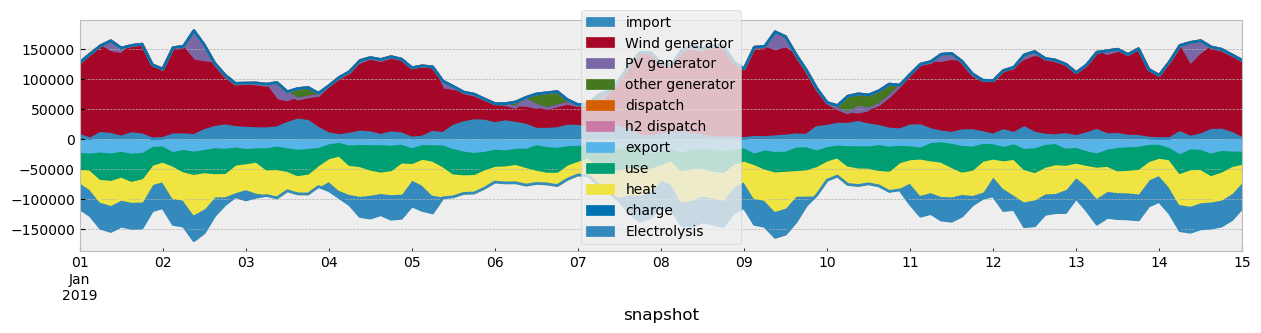

In [252]:
import pandas as pd
import myUtils as utils
import importlib
importlib.reload(utils)

df = pd.DataFrame(index = n.snapshots)


importLinkIds = utils.de_import_elec_grouper(n, 'Link').tolist()
importLinIds = utils.de_import_elec_grouper(n, 'Line').tolist()
importLineRIDS = utils.de_import_elec_reverse_grouper(n, 'Line').tolist()

df['import'] = - n.links_t.p1[importLinkIds].sum(axis=1) \
  - n.lines_t.p1[importLinIds].clip(upper=0).sum(axis=1) \
  - n.lines_t.p0[importLineRIDS].clip(upper=0).sum(axis=1)


generatorGeneratorIds =  utils.de_generator_grouper(n, 'Generator').tolist()
generatorLinkIds =  utils.de_generator_grouper(n, 'Link').tolist()


windGeneratorP = utils.getNTimePropByGroup(n, 'Generator', 'p', utils.de_wind_generator_grouper)
df['Wind generator'] =  windGeneratorP.sum(axis=1)
pvGeneratorP = utils.getNTimePropByGroup(n, 'Generator', 'p', utils.de_pv_generator_grouper)
df['PV generator'] =  pvGeneratorP.sum(axis=1)
co2GeneratorP = - utils.getNTimePropByGroup(n, 'Link', 'p1', utils.de_co2_generator_grouper)
rorGeneratorP = utils.getNTimePropByGroup(n, 'Generator', 'p', utils.de_ror_generator_grouper)

df['other generator'] =  co2GeneratorP.sum(axis=1) + rorGeneratorP.sum(axis=1) 


storeStorageIds = utils.de_elec_store_grouper(n, 'StorageUnit').tolist()
storeStoreIds = utils.de_elec_store_grouper(n, 'Store').tolist()
df['dispatch'] = n.storage_units_t.p_dispatch[storeStorageIds].sum(axis=1) \
  + n.stores_t.p[storeStoreIds].clip(lower=0).sum(axis=1)

ids = utils.de_h2_dispatch_grouper(n, 'Link').tolist()
df['h2 dispatch'] = - n.links_t.p1[ids].sum(axis=1)
# use
exportLinkIds = utils.de_export_elec_grouper(n, 'Link').tolist()
exportLinIds = utils.de_export_elec_grouper(n, 'Line').tolist()
df['export'] = - n.links_t.p0[exportLinkIds].sum(axis=1) \
  - n.lines_t.p0[exportLinIds].clip(lower=0).sum(axis=1) \
  - n.lines_t.p1[importLineRIDS].clip(lower=0).sum(axis=1)


useLinkIds = utils.de_elec_use_grouper(n, 'Link').tolist()
useLoadIds = utils.de_elec_use_grouper(n, 'Load').tolist()

df['use'] = - n.loads_t.p[useLoadIds].sum(axis=1)     
df['heat'] =  -n.links_t.p0[useLinkIds].clip(lower=0).sum(axis=1)

storeStorageIds = utils.de_elec_store_grouper(n, 'StorageUnit').tolist()


storeStoreIds = utils.de_elec_store_grouper(n, 'Store').tolist()
useElectrolysisIds = utils.de_h2_Electrolysis_grouper(n, 'Link').tolist()
df['charge'] = - n.storage_units_t.p[storeStorageIds].clip(upper=0).sum(axis=1)\
  + n.stores_t.p[storeStoreIds].clip(upper=0).sum(axis=1) 

df['Electrolysis'] = - n.links_t.p0[useElectrolysisIds].sum(axis=1) 

# total_use = (df['export'] + df['use']  + df['heat'])
# total_produce= (df['import'] + df['PV generator'] + df['dispatch'])


df['2019-1-1 00:00:00': '2019-1-15 00:00:00'].plot(kind='area', figsize=(15,3))


<Axes: xlabel='snapshot'>

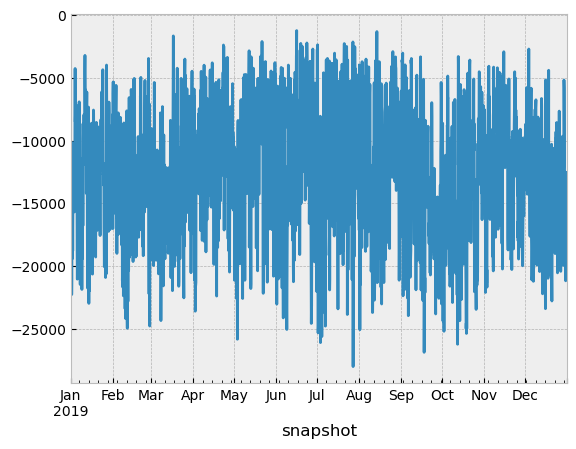

In [240]:
exportLinkIds = utils.de_export_elec_grouper(n, 'Link').tolist()
exportLinIds = utils.de_export_elec_grouper(n, 'Line').tolist()
df['export'] = - n.links_t.p0[exportLinkIds].sum(axis=1) \
  - n.lines_t.p0[exportLinIds].clip(lower=0).sum(axis=1) \
  - n.lines_t.p1[importLineRIDS].clip(lower=0).sum(axis=1)

df['export'].plot()

In [242]:
import myUtils as utils
import importlib
importlib.reload(utils)
de_h2_dispatch_grouper

generator_df = utils.getNByGroup(n, 'Generator', utils.de_generator_grouper)
generators = generator_df.groupby('carrier').sum().p_nom_opt / 1e3
g_links_df = utils.getNByGroup(n, 'Link', utils.de_generator_grouper)
generatorLinks = g_links_df.groupby('carrier').sum().p_nom_opt / 1e3

h2_df = utils.getNByGroup(n, 'Link', utils.de_h2_dispatch_grouper)
h2s =  h2_df.groupby('carrier').sum().p_nom_opt / 1e3

pd.concat([generators, generatorLinks,h2s])

carrier
nuclear                             4.06600
offwind-ac                          1.25053
offwind-dc                          5.78421
offwind-float                       0.52025
onwind                            158.30021
solar                              50.28718
solar rooftop                     107.17029
solar-hsat                          0.00019
OCGT                               61.96930
urban central CHP                  51.04028
urban central solid biomass CHP     5.66299
Name: p_nom_opt, dtype: float64